In [3]:
import json
import spacy
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [16]:
# Charger meta.jsonl
with open('../data/meta.jsonl', 'r', encoding='utf-8') as f:
    meta_data = [json.loads(line) for line in f]

# Charger reviews.jsonl
with open('../data/reviews.jsonl', 'r', encoding='utf-8') as f:
    reviews_data = [json.loads(line) for line in f]


In [17]:
reviews_data

[{'rating': 4.0,
  'title': 'No white background! It’s clear!',
  'text': 'I bought this bc I thought it had the nice white background. Turns out it’s clear & since my phone is blue it doesn’t look anything like this.  If I had known that I would have purchased something else. It works ok.',
  'images': [{'small_image_url': 'https://images-na.ssl-images-amazon.com/images/I/B1PrCo7ZjXS._SL256_.jpg',
    'medium_image_url': 'https://images-na.ssl-images-amazon.com/images/I/B1PrCo7ZjXS._SL800_.jpg',
    'large_image_url': 'https://images-na.ssl-images-amazon.com/images/I/B1PrCo7ZjXS._SL1600_.jpg',
    'attachment_type': 'IMAGE'}],
  'asin': 'B08L6L3X1S',
  'parent_asin': 'B08L6L3X1S',
  'user_id': 'AFKZENTNBQ7A7V7UXW5JJI6UGRYQ',
  'timestamp': 1612044451196,
  'helpful_vote': 0,
  'verified_purchase': True},
 {'rating': 5.0,
  'title': 'Awesome!  Great price!  Works well!',
  'text': 'Perfect. How pissed am I that I recently paid $20 for 1 Fitbit cable and promptly lost the damned thing? 

In [18]:
meta_data

[{'main_category': 'Cell Phones & Accessories',
  'title': 'ARAREE Slim Diary Cell Phone Case for Samsung Galaxy Note 5 - Retail Packaging - Coral Pink',
  'average_rating': 3.8,
  'rating_number': 5,
  'features': ['Genuine Cow leather with 6 different colors',
   '3 Pockets for ID, Cards and receipts',
   'The inside skin is made of microsuede, polycarbonate',
   "It doesn't have magnets The inner PC case color is gold",
   'Made in Korea'],
  'description': ["JUST LOOK, You can tell the difference. Make everyday more convenient, it is slim but has big rooms. If you are looking for a rich and luxurious appearance, look no further. These double shoulders are the perfect leather for creating attractive finished belts, straps and wallets. It doesn't only show the perfect weight for accessories where rugged durability is needed but also has a natural finish and coarse grain."],
  'price': None,
  'images': [{'thumb': 'https://m.media-amazon.com/images/I/51Q9w96zIQL._AC_SR38,50_.jpg',
   

In [19]:
documents = [review['title'] + " " + review['text'] for review in reviews_data]
documents

['No white background! It’s clear! I bought this bc I thought it had the nice white background. Turns out it’s clear & since my phone is blue it doesn’t look anything like this.  If I had known that I would have purchased something else. It works ok.',
 'Awesome!  Great price!  Works well! Perfect. How pissed am I that I recently paid $20 for 1 Fitbit cable and promptly lost the damned thing?  Extremely pissed!  I keep the spare in my medicine bag so hopefully I won’t lose it and my grandson can’t get to it and try to use it as a belt or a dog leash or any of the other nutty things he’s been using the other one for.',
 'Worked but took an hour to install Overall very happy with the end result. If you hate puzzles don’t do it. I love puzzles and it worked for me. Took a lot of concentration and attention to detail and about an hour! The YouTube video helped a ton with installing the new screen. Highly recommend using a how to video when replacing your screen. The tools and supplies they

In [21]:
nlp = spacy.load('en_core_web_sm')
tokenized_documents = [[token.text for token in nlp(doc)] for doc in documents]

In [22]:
lemmatized_documents = [[token.lemma_ for token in nlp(doc)] for doc in documents]

In [23]:
filtered_documents = [[token.text for token in nlp(doc) if not token.is_stop] for doc in documents]

In [24]:
cleaned_documents = [[token.text for token in nlp(doc) if token.is_alpha] for doc in documents]

In [26]:
# Fréquences des mots
all_words = [word for doc in cleaned_documents for word in doc]
word_frequencies = Counter(all_words)

# Afficher les mots les plus fréquents
print(word_frequencies.most_common(20))


[('the', 2099), ('I', 1785), ('it', 1523), ('a', 1325), ('to', 1324), ('and', 1294), ('is', 901), ('my', 798), ('phone', 797), ('for', 741), ('of', 653), ('case', 622), ('that', 548), ('this', 531), ('with', 502), ('in', 500), ('on', 484), ('It', 476), ('but', 441), ('have', 419)]


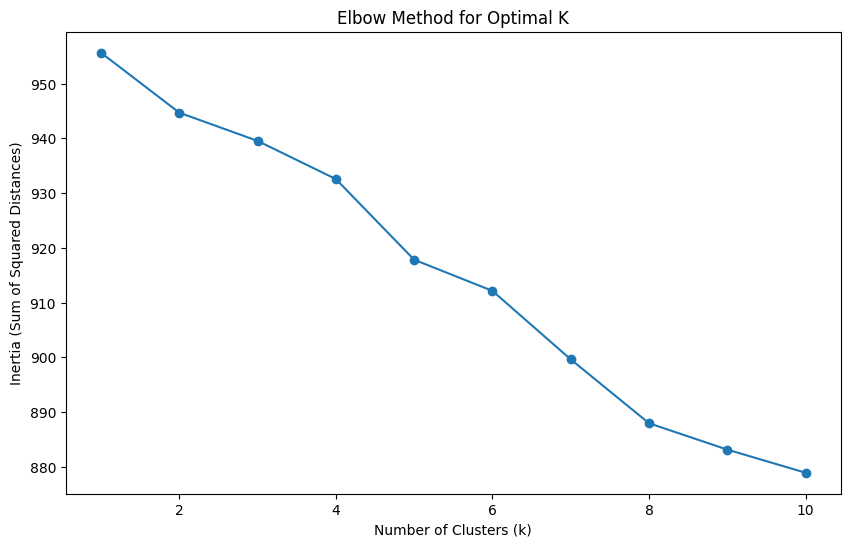

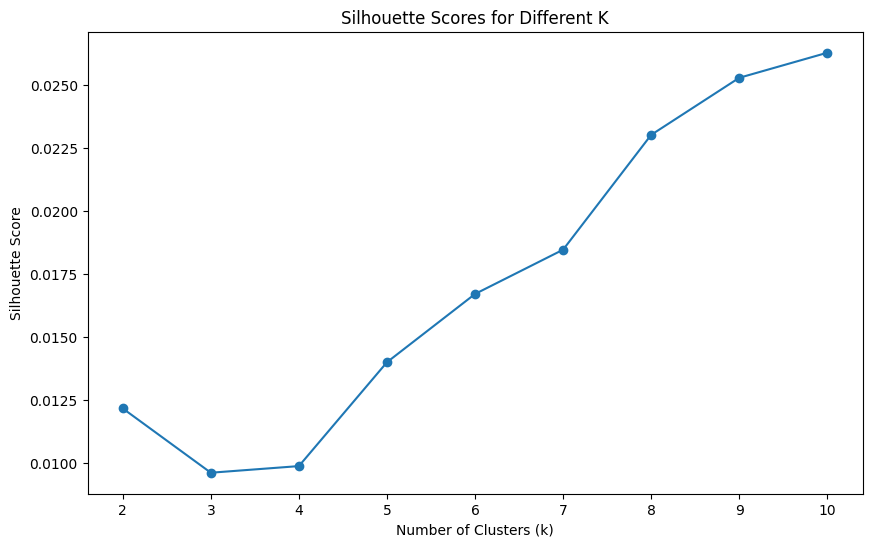

In [6]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import json

# Load Preprocessed Data
def load_cleaned_reviews(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

# Path to preprocessed reviews file
cleaned_reviews_file = "processed_reviews.json"

# Load reviews and prepare corpus
documents = load_cleaned_reviews(cleaned_reviews_file)
corpus = [" ".join(doc["text"]) for doc in documents]  # Join tokens into strings

# Generate TF-IDF Matrix
vectorizer = TfidfVectorizer(max_features=1000)  # Limit to top 1000 features
tfidf_matrix = vectorizer.fit_transform(corpus)  # Sparse matrix

# Elbow Method for Optimal K
def elbow_method(tfidf_matrix, k_range):
    inertia = []  # Sum of squared distances for each k
    silhouette_scores = []  # Silhouette scores for each k
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(tfidf_matrix)
        
        # Calculate inertia (sum of squared distances to nearest cluster center)
        inertia.append(kmeans.inertia_)
        
        # Calculate silhouette score
        if k > 1:  # Silhouette score requires at least 2 clusters
            silhouette_scores.append(silhouette_score(tfidf_matrix, cluster_labels))
        else:
            silhouette_scores.append(None)
    
    return inertia, silhouette_scores

# Define range for k
k_range = range(1, 11)  # Test k values from 1 to 10

# Run elbow method
inertia, silhouette_scores = elbow_method(tfidf_matrix, k_range)

# Plot Inertia (Elbow Curve)
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range[1:], silhouette_scores[1:], marker='o')  # Skip silhouette for k=1
plt.title("Silhouette Scores for Different K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()


In [1]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Number of CUDA devices
print(torch.cuda.get_device_name(0))  # Name of the GPU


True
1
NVIDIA GeForce RTX 3060


In [14]:
from openai import OpenAI
from dotenv import load_dotenv
import os

# Initialize OpenAI API
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("OpenAI API key is missing from the .env file.")
# Set your API key

client = OpenAI(api_key=api_key)

completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": "Write a haiku about recursion in programming."
        }
    ]
)

print(completion.choices[0].message)


ChatCompletionMessage(content='Code calls itself back,  \nFractal logic unfolds deep,  \nInfinite layers.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None)
